# Image Similarity
This notebook will explore the potential of an image similarity model using MobileNet_V2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras import Model
from keras.models import load_model
from keras_applications import mobilenet_v2
from tqdm import tqdm

from utils.analyzer import Analyzer
from utils.image_similarity import get_closest_images, get_concatenated_images

/Users/dave/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set global variables

In [2]:
MODEL_DIRECTORY = 'saved_models'
MODEL_SAVED_FILEPATH = '2018_07_29_mobilenet_v2_8925'

IMAGE_TYPES = sorted(['bed', 'lamp', 'couch', 'table', 'chair'])
IMAGES_PER_TYPE = 100
IMAGES_COUNT = len(IMAGE_TYPES) * IMAGES_PER_TYPE
IMAGE_SIZE = 224
MODEL = mobilenet_v2

## Load analyzer and model

In [3]:
analyzer = Analyzer()

model_classifier = load_model('{}/{}.h5'.format(MODEL_DIRECTORY, MODEL_SAVED_FILEPATH),
                              custom_objects={'relu6': mobilenet_v2.relu6})

## Load images
Put that analyzer to use and load the images!

Remember, **images_unprocessed** are for viewing, **images_processed** are the inputs to the model.

In [4]:
images_unprocessed, _ = analyzer.load_images(
    image_types=IMAGE_TYPES,
    directory='../downloaded_images/fine_tuning/',
    images_per_type=IMAGES_PER_TYPE,
    image_size=IMAGE_SIZE,
    process=False,
    model=MODEL
)

In [5]:
images_processed, classes_processed = analyzer.load_images(
    image_types=IMAGE_TYPES,
    directory='../downloaded_images/fine_tuning/',
    images_per_type=IMAGES_PER_TYPE,
    image_size=IMAGE_SIZE,
    process=True,
    model=MODEL
)

Mapping:
{'bed': 0, 'chair': 1, 'couch': 2, 'lamp': 3, 'table': 4}


## Create image similarity model
Below is our current classifier model. To create the image similarity model, all we need to do is remove the top two layers. The idea for this method was taken from this [notebook](https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb).

In [6]:
model_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


It's very important that the layer `global_average_pooling2d_1`, rather than any other, is selected. We want all dimensions (height, width, depth/convolutional layers) of an image to be included when measuring similarity. In the `global_average_pooling2d_1` layer, the dimensions of an image have been reduced to one. This simplifies the process of calculating the distance between images. This distance is calculated by taking the predicted/output values of `model_image_similarity`. Each input image will become a 1280-dimension array. Each value is the output of a neuron. **Note:** the quality of these predictions is subject to the quality of our classifier. This is because the weights of the neurons were updated during the [fine-tuning of our classifier](https://github.com/VanLifeInc/models/blob/master/image_classification/mobile_net_v2_fine_tune.ipynb).

In [7]:
model_image_similarity = Model(inputs=model_classifier.input,
                               outputs=model_classifier.get_layer('global_average_pooling2d_1').output)
model_image_similarity.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


## Create array for each image

In [8]:
images_predicted = []
for image in tqdm(images_processed):
    prediction = model_image_similarity.predict([[image]])[0]
    images_predicted.append(prediction)

100%|██████████| 500/500 [01:24<00:00,  5.93it/s]


## Show results
Within each set of images there are three things to note:
1. The distances: This is the calcuated distance between each image. The smaller the number, the more similar the images.
2. Top image: This is the input image. All other images will have their distances measured relative to this image.
3. Row of images: According to the calculation, these images are the most similar to the input image.

### Some things to note:
- Measuring similarity: This article recommended using manhattan distance, rather than euclidean, to measure image similarity. From the article:
> Their results suggest that, in the domain of natural images of the kind we have used, the Manhattan distance may better capture the human notions of image similarity.
- Setting a cut-off: In the future, we could only return images with a calculated distance of less than X. I haven't really explored what this cut-off value should be, nor do I think it's necessary to do in the near future, given our priorities. 
- Quality of results: We're only using a sample of our images and these images still have not been curated. If we were to retrain our classifier model using all of our high-quality images, and only use these images when measuring similarity, I expect the returned images would be more similar.

Distance to each image:
[471.344, 479.4381, 479.78067, 487.46716, 496.88696]


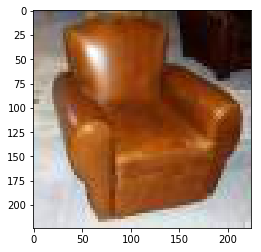

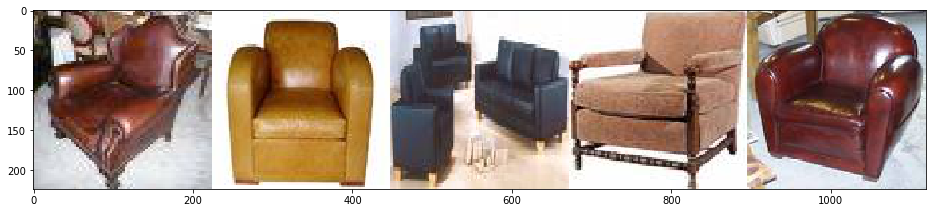

Distance to each image:
[388.23303, 408.53937, 419.8645, 428.79956, 444.3387]


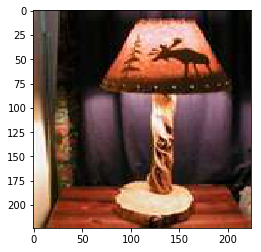

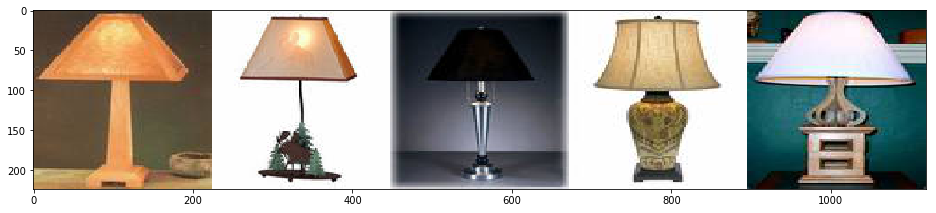

Distance to each image:
[488.16925, 502.57465, 512.76624, 519.1229, 532.2799]


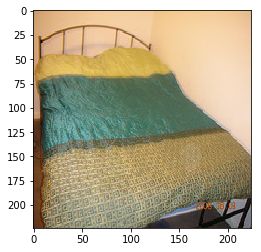

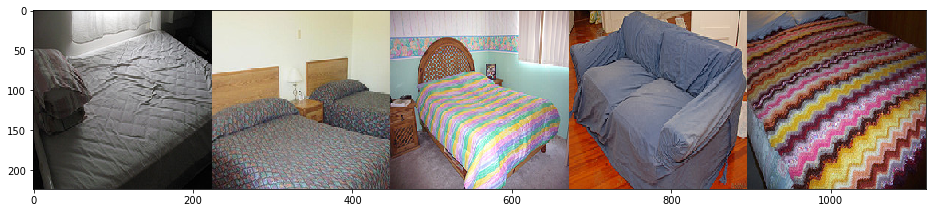

Distance to each image:
[465.6963, 469.26312, 470.33267, 474.97113, 494.94183]


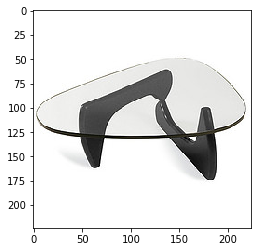

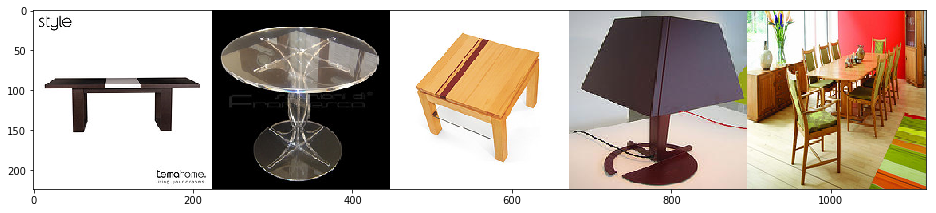

Distance to each image:
[448.14792, 455.8937, 460.39816, 476.17874, 497.02313]


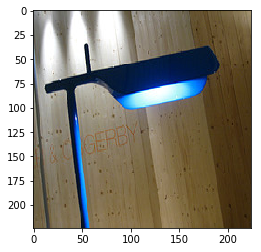

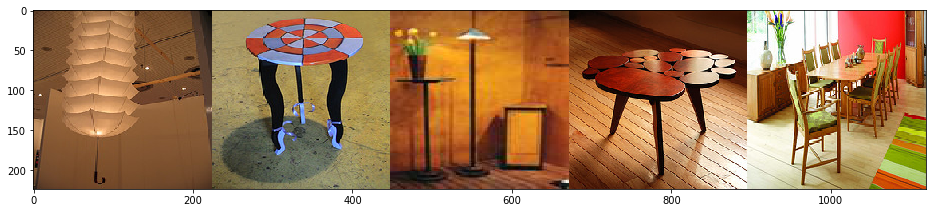

In [36]:
random_image_indcies = np.random.choice(IMAGES_COUNT, 5, replace=False)

for index in random_image_indcies:

    plt.imshow(np.uint8(images_unprocessed[index]))
    distances, indicies_closest = get_closest_images(images_predicted, index)
    print('Distance to each image:\n{}'.format(distances))
    plt.figure(figsize=(16,12))
    plt.imshow(get_concatenated_images(images_unprocessed, indicies_closest))

    plt.show()